In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

import os
import glob
import re

import sys
sys.path.append("./src/") 

import mnist_data
import plot_utils
import gzip

### Read time series data

In [2]:
def readData(filelists):

    try:
        savedir = './data'

        mergeddata = []
        for file in filelists:
            filename = file
            stocksavedir = savedir+'/'+filename

            np_data = []
            for _inputname in ['np_train','np_test']:
                with gzip.open( stocksavedir+'/'+_inputname+'.npy.gz', 'r') as infile:
                    np_data.append(np.load(infile))

            df_data = []
            for _inputname in ['df_train','df_test']:
                df_data.append(pd.read_pickle(stocksavedir+'/'+_inputname+'.pkl'))
            
            mergeddata.append([np_data[0],np_data[1],df_data[0],df_data[1]])

        return mergeddata

    except Exception as e:
        print(e)



### build variational autoencoder

In [2]:
class vae:
    def __init__(self,session,learning_rate,dense_layers,dense_funcs,dim_z,dim_out):

        self.session = session
        self.dim_in = dim_out
        self.dim_out = dim_out
        self.dim_z = dim_z
        
        self.lrate = learning_rate
        self.dense_layers = dense_layers
        self.dense_funcs = dense_funcs
        
        self.model_name = 'vae'
        self.logs_dir = './model'
        self._build_network()
        
    def _build_network(self):
        
        self.x_hat = tf.placeholder(tf.float32, shape=[None, self.dim_in], name='input_denoising')
        self.x = tf.placeholder(tf.float32, shape=[None, self.dim_out], name='target')

        # dropout
        self.keep_prob = tf.placeholder(tf.float32, name='keep_prob')

        # input for PMLR
        self.z_in = tf.placeholder(tf.float32, shape=[None, dim_z], name='latent_variable')
        
        self.encoder_dense_layers = self.dense_layers+[self.dim_z]
        self.encoder_dense_funcs = self.dense_funcs
        print("encoder_dense_layers {}".format(self.encoder_dense_layers))
        
        self.mu,self.sigma = self.encoder(self.x_hat,self.encoder_dense_layers,self.encoder_dense_funcs,self.keep_prob)
        
        print("mu:{} sigma:{}".format(self.mu.shape,self.sigma.shape))
        # sampling by re-parameterization technique
        self.z = self.mu + self.sigma * tf.random_normal(tf.shape(self.mu), 0, 1, dtype=tf.float32)
        print("encoder output z:{}".format(self.z.shape))

        self.decoder_dense_layers = self.dense_layers[::-1]+[self.dim_out]
        self.decoder_activ = self.encoder_dense_funcs[::-1]
        print("decoder_dense_layers {}".format(self.decoder_dense_layers))
        
        # decoding
        self.y = self.decoder(self.z, self.decoder_dense_layers,self.decoder_activ, self.keep_prob)
        self.y = tf.clip_by_value(self.y, 1e-8, 1 - 1e-8)
        print("decoder output y:{}".format(self.y.shape))
        # loss
        self.marginal_likelihood = tf.reduce_sum(self.x * tf.log(self.y) + (1 - self.x) * tf.log(1 - self.y), 1)
        self.KL_divergence = 0.5 * tf.reduce_sum(tf.square(self.mu) + tf.square(self.sigma) - tf.log(1e-8 + tf.square(self.sigma)) - 1, 1)

        self.marginal_likelihood = tf.reduce_mean(self.marginal_likelihood)
        self.KL_divergence = tf.reduce_mean(self.KL_divergence)

        self.ELBO = self.marginal_likelihood - self.KL_divergence

        self.loss = -self.ELBO
        
        self.decoded = self.sample_decoder(self.z_in, self.dim_out)
        
        self.train_op = tf.train.AdamOptimizer(self.lrate).minimize(self.loss)
        
        self.global_step = tf.Variable(0, name='global_step',trainable=False)
        self.saver = tf.train.Saver(max_to_keep=1)
    
    def save(self, step):
        model_name = self.model_name + ".model"
                
        model_logs_dir = self.logs_dir
        if not os.path.exists(model_logs_dir):
            os.makedirs(model_logs_dir)
            
        self.saver.save(
            self.session,
            os.path.join(model_logs_dir, model_name),
            global_step=step
        )
    def load(self):
    
        ckpt = tf.train.get_checkpoint_state(self.logs_dir)
        
        if ckpt and ckpt.model_checkpoint_path:
            ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
            # print('ckpt_name {} self.logs_dir {}'.format(ckpt_name,self.logs_dir))
            self.saver.restore(self.session, os.path.join(self.logs_dir, ckpt_name))
            counter = int(next(re.finditer("(\d+)(?!.*\d)", ckpt_name)).group(0))
            print(" [*] Success to read {}".format(ckpt_name))
            return True, counter

        else:
            print(" [*] Failed to find a " +self.logs_dir+ " checkpoint")
            return False, 0
    
    def sample_decoder(self,z, dim_img):

        # decoding
        y = self.decoder(z, self.decoder_dense_layers,self.decoder_activ, 1.0, reuse=True)
        return y
    
    def encoder(self,x, dense_layers,dense_func,keep_prob):
        with tf.variable_scope("encoder"):

            # initializers
            w_init = tf.contrib.layers.variance_scaling_initializer()
            b_init = tf.constant_initializer(0.)

            # dense layers
            dense_input_shape = x.get_shape()[1]
            dense_input = x
            for _i,_n_hidden in enumerate(dense_layers[:-1]):
                net_w = tf.get_variable('w'+str(_i),[dense_input_shape,_n_hidden],initializer=w_init)
                net_b = tf.get_variable('b'+str(_i),[_n_hidden],initializer = b_init)
                net_h = tf.matmul(dense_input,net_w) + net_b 
                if dense_func[_i] == 'elu':
                    actfunc = tf.nn.elu
                elif dense_func[_i] == 'tanh':
                    actfunc = tf.nn.tanh
                net_h = actfunc(net_h)
                net_h = tf.nn.dropout(net_h,keep_prob)
                dense_input_shape = net_h.get_shape()[1]
                dense_input = net_h

            # final output
            final_w = tf.get_variable("w_final",[dense_input.get_shape()[1],dense_layers[-1]*2],initializer = w_init)
            final_b = tf.get_variable("b_final",[dense_layers[-1]*2],initializer=b_init)
            gaussian_params = tf.matmul(dense_input,final_w) + final_b

            mean = gaussian_params[:,:dense_layers[-1]]
            stddev = 1e-6 +tf.nn.softplus(gaussian_params[:,dense_layers[-1]:])
            print("gaussian encoder mean:{} ".format(mean.shape))


        return mean, stddev
    
    # Bernoulli as decoder
    # bernoulli_decoder(z, [500,500,784],['tanh','elu'], keep_prob, reuse=False)
    def decoder(self,z, dense_layers,dense_func, keep_prob, reuse=False):

        with tf.variable_scope("decoder", reuse=reuse):
            # initializers
            w_init = tf.contrib.layers.variance_scaling_initializer()
            b_init = tf.constant_initializer(0.)

            # dense layers
            dense_input_shape = z.get_shape()[1]
            dense_input = z
            for _i,_n_hidden in enumerate(dense_layers[:-1]):
                net_w = tf.get_variable('w'+str(_i),[dense_input_shape,_n_hidden],initializer=w_init)
                net_b = tf.get_variable('b'+str(_i),[_n_hidden],initializer = b_init)
                net_h = tf.matmul(dense_input,net_w) + net_b 
                if dense_func[_i] == 'elu':
                    actfunc = tf.nn.elu
                elif dense_func[_i] == 'tanh':
                    actfunc = tf.nn.tanh
                net_h = actfunc(net_h)
                net_h = tf.nn.dropout(net_h,keep_prob)
                dense_input_shape = net_h.get_shape()[1]
                dense_input = net_h

            # final output
            final_w = tf.get_variable("w_final",[dense_input.get_shape()[1],dense_layers[-1]],initializer = w_init)
            final_b = tf.get_variable("b_final",[dense_layers[-1]],initializer=b_init)
            y = tf.sigmoid(tf.matmul(dense_input,final_w)+final_b)


        return y


In [3]:
train_total_data, train_size, _, _, test_data, test_labels = mnist_data.prepare_MNIST_data()
n_samples = train_size

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


In [4]:
RESULTS_DIR = './results'

# network architecture
ADD_NOISE = True # Denoising Auto encoder

IMAGE_SIZE_MNIST = 28

dim_out = IMAGE_SIZE_MNIST**2  # number of pixels for a MNIST image ,784
dim_z = 2#20 # latent vector size

# train
n_epochs = 2
batch_size = 128
learn_rate = 1e-3

# Plot
PRR = True                           # Plot Reproduce Result
PRR_n_img_x = 10              # number of images along x-axis in a canvas
PRR_n_img_y = 10              # number of images along y-axis in a canvas
PRR_resize_factor = 1.0  # resize factor for each image in a canvas

PMLR = True                            # Plot Manifold Learning Result
PMLR_n_img_x = 50            # number of images along x-axis in a canvas
PMLR_n_img_y = 50            # number of images along y-axis in a canvas
PMLR_resize_factor = 1.0   # resize factor for each image in a canvas
PMLR_z_range = 2.0            # range for random latent vector
PMLR_n_samples = 5000        # number of labeled samples to plot a map from input data space to the latent space

# train
total_batch = int(n_samples / batch_size)
min_tot_loss = 1e99

# Plot for reproduce performance
if PRR:
    PRR = plot_utils.Plot_Reproduce_Performance(RESULTS_DIR, PRR_n_img_x, PRR_n_img_y, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST, PRR_resize_factor)

    x_PRR = test_data[0:PRR.n_tot_imgs, :]

    x_PRR_img = x_PRR.reshape(PRR.n_tot_imgs, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST)
    PRR.save_images(x_PRR_img, name='input.jpg')

    if ADD_NOISE:
        x_PRR = x_PRR * np.random.randint(2, size=x_PRR.shape)
        x_PRR += np.random.randint(2, size=x_PRR.shape)

        x_PRR_img = x_PRR.reshape(PRR.n_tot_imgs, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST)
        PRR.save_images(x_PRR_img, name='input_noise.jpg')

# Plot for manifold learning result
if PMLR and dim_z == 2:

    PMLR = plot_utils.Plot_Manifold_Learning_Result(RESULTS_DIR, PMLR_n_img_x, PMLR_n_img_y, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST, PMLR_resize_factor, PMLR_z_range)

    x_PMLR = test_data[0:PMLR_n_samples, :]
    id_PMLR = test_labels[0:PMLR_n_samples, :]

    if ADD_NOISE:
        x_PMLR = x_PMLR * np.random.randint(2, size=x_PMLR.shape)
        x_PMLR += np.random.randint(2, size=x_PMLR.shape)

#     decoded = decoder(z_in, dim_out)


z shape:(2500, 2)
self.z [[2.         2.        ]
 [2.         1.91836735]
 [2.         1.83673469]
 [2.         1.75510204]
 [2.         1.67346939]
 [2.         1.59183673]
 [2.         1.51020408]
 [2.         1.42857143]
 [2.         1.34693878]
 [2.         1.26530612]]


encoder_dense_layers [500, 500, 2]
gaussian encoder mean:(?, 2) 
mu:(?, 2) sigma:(?, 2)
encoder output z:(?, 2)
decoder_dense_layers [500, 500, 784]
decoder output y:(?, 784)
epoch 0: L_tot 214.01 L_likelihood 209.37 L_divergence 4.65
epoch 1: L_tot 216.64 L_likelihood 211.68 L_divergence 4.96


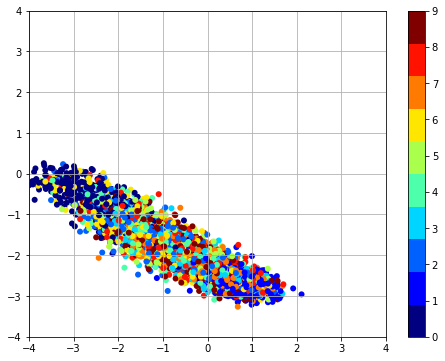

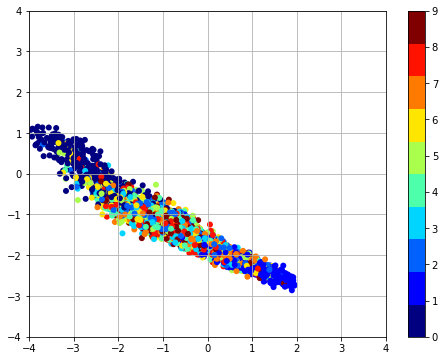

In [5]:

with tf.Session() as sess:
    
    learning_rate= learn_rate
    dense_layers = [500,500]
    dense_funcs = ['elu','tanh']
    dim_z = 2#20 # latent vector size
    dim_out = IMAGE_SIZE_MNIST**2  # number of pixels for a MNIST image ,784
    

    autoencoder = vae(sess,learning_rate,dense_layers,dense_funcs,dim_z,dim_out)
    
    sess.run(tf.global_variables_initializer(), feed_dict={autoencoder.keep_prob : 0.9})
    

    for epoch in range(n_epochs):

        # Random shuffling
        np.random.shuffle(train_total_data)
        train_data_ = train_total_data[:, :-mnist_data.NUM_LABELS] # (n_samples,784)

        # Loop over all batches
        for i in range(total_batch):
            # Compute the offset of the current minibatch in the data.
            offset = (i * batch_size) % (n_samples)
            batch_xs_input = train_data_[offset:(offset + batch_size), :]

            batch_xs_target = batch_xs_input

            # add salt & pepper noise
            if ADD_NOISE:
                batch_xs_input = batch_xs_input * np.random.randint(2, size=batch_xs_input.shape)
                batch_xs_input += np.random.randint(2, size=batch_xs_input.shape)

            _, tot_loss, loss_likelihood, loss_divergence = sess.run(
                (autoencoder.train_op, autoencoder.loss, -autoencoder.marginal_likelihood, autoencoder.KL_divergence),
                feed_dict={autoencoder.x_hat: batch_xs_input, autoencoder.x: batch_xs_target, autoencoder.keep_prob : 0.9})

        # print cost every epoch
        print("epoch %d: L_tot %03.2f L_likelihood %03.2f L_divergence %03.2f" % (epoch, tot_loss, loss_likelihood, loss_divergence))


        # if minimum loss is updated or final epoch, plot results
        if min_tot_loss > tot_loss or epoch+1 == n_epochs:
            min_tot_loss = tot_loss
            # Plot for reproduce performance
            if PRR:
                y_PRR = sess.run(autoencoder.y, feed_dict={autoencoder.x_hat: x_PRR, autoencoder.keep_prob : 1})
                y_PRR_img = y_PRR.reshape(PRR.n_tot_imgs, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST)
                PRR.save_images(y_PRR_img, name="/PRR_epoch_%02d" %(epoch) + ".jpg")

            # Plot for manifold learning result
            if PMLR and dim_z == 2:
                y_PMLR = sess.run(autoencoder.decoded, feed_dict={autoencoder.z_in: PMLR.z, autoencoder.keep_prob : 1})
                y_PMLR_img = y_PMLR.reshape(PMLR.n_tot_imgs, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST)
                PMLR.save_images(y_PMLR_img, name="/PMLR_epoch_%02d" % (epoch) + ".jpg")

                # plot distribution of labeled images
                z_PMLR = sess.run(autoencoder.z, feed_dict={autoencoder.x_hat: x_PMLR, autoencoder.keep_prob : 1})
                PMLR.save_scattered_image(z_PMLR,id_PMLR, name="/PMLR_map_epoch_%02d" % (epoch) + ".jpg")

    autoencoder.save(1)

encoder_dense_layers [500, 500, 2]
gaussian encoder mean:(?, 2) 
mu:(?, 2) sigma:(?, 2)
encoder output z:(?, 2)
decoder_dense_layers [500, 500, 784]
decoder output y:(?, 784)
INFO:tensorflow:Restoring parameters from ./model/vae.model-1
 [*] Success to read vae.model-1
PMLR.z: [[ 0.          0.        ]
 [ 0.         -0.02040816]]
input:x_PMLR: (5000, 784) z_PMLR: (5000, 2)


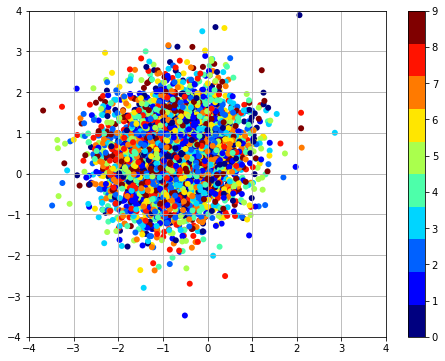

In [5]:

with tf.Session() as sess:
    learning_rate= learn_rate
    dense_layers = [500,500]
    dense_funcs = ['elu','tanh']
    dim_z = 2#20 # latent vector size
    dim_out = IMAGE_SIZE_MNIST**2  # number of pixels for a MNIST image ,784
    
    
    autoencoder = vae(sess,learning_rate,dense_layers,dense_funcs,dim_z,dim_out)
    autoencoder.load()
    
    sess.run(tf.global_variables_initializer(), feed_dict={autoencoder.keep_prob : 0.9})
    
    
    if PMLR and dim_z == 2:
        epoch = 0
        
        PMLR.z = np.rollaxis(np.mgrid[0:-1:50j, 0:-1:50j], 0, 3)
        PMLR.z = PMLR.z.reshape([-1, 2])
        print("PMLR.z: {}".format(PMLR.z[:2]))
        y_PMLR = sess.run(autoencoder.decoded, feed_dict={autoencoder.z_in: PMLR.z, autoencoder.keep_prob : 1})
        y_PMLR_img = y_PMLR.reshape(PMLR.n_tot_imgs, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST)
        PMLR.save_images(y_PMLR_img, name="/PMLR_epoch_%02d" % (epoch) + ".jpg")

        # plot distribution of labeled images
        z_PMLR = sess.run(autoencoder.z, feed_dict={autoencoder.x_hat: x_PMLR, autoencoder.keep_prob : 1})
        print("input:x_PMLR: {} z_PMLR: {}".format(x_PMLR.shape,z_PMLR.shape))
        PMLR.save_scattered_image(z_PMLR,id_PMLR, name="/PMLR_map_epoch_%02d" % (epoch) + ".jpg")